In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def create_dataset(train_root, val_root, test_root):
    # Define data augmentation transforms
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=.5),
        transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=.5),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Define the data loaders
    train_dataset = ImageFolder(root=train_root, transform=train_transform)
    validation_dataset = ImageFolder(root=val_root, transform=test_transform)
    test_dataset = ImageFolder(root=test_root, transform=test_transform)

    return train_dataset, validation_dataset, test_dataset

def show_image(dataset, num_images=5):
    # Get some random indices from the dataset
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.samples[idx][0]  # Get the filename
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        plt.axis('off')
    plt.show()


def train_model(train_loader, validation_loader, num_epochs, lr, step_size, gamma, model_name):
    # Check if CUDA is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Load pre-trained model
    torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
    if model_name == 'resnet152':
        from torchvision.models import resnet152, ResNet152_Weights
        model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        
    elif model_name == 'densenet161':
        from torchvision.models import densenet161, DenseNet161_Weights
        model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)
        
    elif model_name == 'resnet50':
        from torchvision.models import resnet50, ResNet50_Weights
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    elif model_name == 'vgg19':
        from torchvision.models import vgg19, VGG19_Weights
        model = models.vgg19(weights=VGG19_Weights.DEFAULT)

    elif model_name == 'resnet101':
        from torchvision.models import resnet101, ResNet101_Weights
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
        
    else:
        raise ValueError("Invalid model type. 'vgg19' 'resnet50' 'resnet101' 'resnet152' or 'densenet161'.")
    
    # Modify the output layer
    num_classes = 2
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    # Move model to the specified device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Training (loss and accuracy)
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
        
        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(validation_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {loss.item():.4f}, "
            f"Validation Loss: {validation_loss:.4f}, "
            f"Train Acc: {train_accuracy:.2f}%, "
            f"Validation Acc: {validation_accuracy:.2f}%")
        
        scheduler.step()  # Step the learning rate scheduler

    # Plot loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend() 

    plt.show()

    return model


def test_model(model, test_loader):
    # check CUDA
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    original_classes = test_loader.dataset.classes

    # confusion matrix
    with torch.no_grad():
        all_predictions = []
        all_labels = []

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Precision、Recall、F1 Score
    classification_rep = classification_report(all_labels, all_predictions, target_names=original_classes)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)


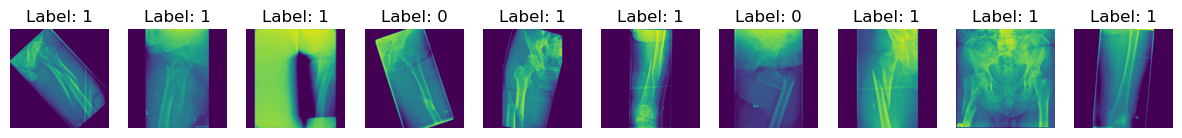

In [23]:
# create dataset
train_root = '/local/data1/honzh073/data/patient_level_dataset/train'
val_root = '/local/data1/honzh073/data/patient_level_dataset/val'
test_root='/local/data1/honzh073/data/patient_level_dataset/test'
train_dataset, validation_dataset, test_dataset = create_dataset(train_root, val_root, test_root)

# show image
show_image(validation_dataset, 10)

# load data
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)



In [25]:
# resnet50
resnet50 = train_model(train_loader, validation_loader, num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='resnet50')


Epoch 1/50, Train Loss: 0.2243, Validation Loss: 0.4582, Train Acc: 78.45%, Validation Acc: 80.60%
Epoch 2/50, Train Loss: 0.1257, Validation Loss: 0.3563, Train Acc: 82.39%, Validation Acc: 83.95%
Epoch 3/50, Train Loss: 0.0430, Validation Loss: 0.2949, Train Acc: 87.45%, Validation Acc: 88.22%
Epoch 4/50, Train Loss: 0.0900, Validation Loss: 0.2505, Train Acc: 90.31%, Validation Acc: 89.49%
Epoch 5/50, Train Loss: 0.0571, Validation Loss: 0.2271, Train Acc: 92.41%, Validation Acc: 90.30%
Epoch 6/50, Train Loss: 0.0420, Validation Loss: 0.2113, Train Acc: 93.13%, Validation Acc: 91.92%
Epoch 7/50, Train Loss: 0.0273, Validation Loss: 0.2051, Train Acc: 93.82%, Validation Acc: 91.45%
Epoch 8/50, Train Loss: 0.0080, Validation Loss: 0.2130, Train Acc: 94.65%, Validation Acc: 92.84%
Epoch 9/50, Train Loss: 0.0045, Validation Loss: 0.2358, Train Acc: 95.53%, Validation Acc: 92.26%
Epoch 10/50, Train Loss: 0.0123, Validation Loss: 0.2688, Train Acc: 95.70%, Validation Acc: 91.45%
Epoch 11/

In [ ]:
# resnet50 test performance
test_model(resnet50, test_loader)


In [ ]:
# resnet101
resnet101 = train_model(train_loader, validation_loader, num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='resnet101')
test_model(resnet101, test_loader)

In [ ]:
# resnet101
densenet161 = train_model(train_loader, validation_loader, num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='densenet161')
test_model(resnet101, test_loader)